In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [4]:
path = "/kaggle/input/plantvillage-dataset/color"

In [5]:
# Loop through each class folder
for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        # Count only files (ignore subfolders, if any)
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [6]:
import os
import shutil
import random
from pathlib import Path

# Reproducibility (optional)
random.seed(42)

# Paths
source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350


os.makedirs(dest_dir, exist_ok=True)


class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)


kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)


    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)


    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)

Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Resize and crop for augmentation
    transforms.RandomHorizontalFlip(),      # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [ ]:
class_names = dataset.classes
num_classes = len(class_names)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FIX: Subset -> access underlying dataset
class_names = train_dataset.dataset.classes
total_class = len(class_names)

learning_rate = 0.0001

model = models.resnet50(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [10]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [11]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim


num_epochs = 50


try:
   
    from torchvision.models import MobileNet_V2_Weights
    model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
except Exception:
    
    model = models.mobilenet_v2(pretrained=True)


for p in model.features.parameters():
    p.requires_grad = False


in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=5)
train_losses, val_losses = [], []


scaler = GradScaler(enabled=(device.type == "cuda"))


for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

  
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with autocast(enabled=(device.type == "cuda")):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break


/tmp/ipykernel_36/638276114.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_36/638276114.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Validation:   0%|          | 0/79 [00:00<?, ?it/s]         /tmp/ipykernel_36/638276114.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Train Loss: 1.4815, Validation Loss: 0.6260
Epoch 2/50


Train Loss: 0.5219, Validation Loss: 0.3873
Epoch 3/50


Train Loss: 0.3544, Validation Loss: 0.2984
Epoch 4/50


Train Loss: 0.2784, Validation Loss: 0.2530
Epoch 5/50


Train Loss: 0.2305, Validation Loss: 0.2280
Epoch 6/50


Train Loss: 0.2036, Validation Loss: 0.2117
Epoch 7/50


Train Loss: 0.1788, Validation Loss: 0.2007
Epoch 8/50


Train Loss: 0.1598, Validation Loss: 0.1802
Epoch 9/50


Train Loss: 0.1406, Validation Loss: 0.1719
Epoch 10/50


Train Loss: 0.1334, Validation Loss: 0.1616
Epoch 11/50


Train Loss: 0.1213, Validation Loss: 0.1674
Epoch 12/50


Train Loss: 0.1086, Validation Loss: 0.1525
Epoch 13/50


Train Loss: 0.1031, Validation Loss: 0.1527
Epoch 14/50


Train Loss: 0.0986, Validation Loss: 0.1527
Epoch 15/50


Train Loss: 0.0952, Validation Loss: 0.1510
Epoch 16/50


Train Loss: 0.0845, Validation Loss: 0.1412
Epoch 17/50


Train Loss: 0.0814, Validation Loss: 0.1436
Epoch 18/50


Train Loss: 0.0758, Validation Loss: 0.1376
Epoch 19/50


Train Loss: 0.0776, Validation Loss: 0.1350
Epoch 20/50


Train Loss: 0.0736, Validation Loss: 0.1441
Epoch 21/50


Train Loss: 0.0690, Validation Loss: 0.1352
Epoch 22/50


Train Loss: 0.0672, Validation Loss: 0.1328
Epoch 23/50


Train Loss: 0.0656, Validation Loss: 0.1375
Epoch 24/50


Train Loss: 0.0599, Validation Loss: 0.1347
Epoch 25/50


Train Loss: 0.0611, Validation Loss: 0.1363
Epoch 26/50


Train Loss: 0.0533, Validation Loss: 0.1326
Epoch 27/50


Train Loss: 0.0563, Validation Loss: 0.1387
Epoch 28/50


Train Loss: 0.0537, Validation Loss: 0.1353
Epoch 29/50


Train Loss: 0.0550, Validation Loss: 0.1346
Epoch 30/50


Train Loss: 0.0541, Validation Loss: 0.1358
Epoch 31/50


Train Loss: 0.0503, Validation Loss: 0.1324
Epoch 32/50


Train Loss: 0.0502, Validation Loss: 0.1271
Epoch 33/50


Train Loss: 0.0547, Validation Loss: 0.1279
Epoch 34/50


Train Loss: 0.0491, Validation Loss: 0.1304
Epoch 35/50


Train Loss: 0.0466, Validation Loss: 0.1279
Epoch 36/50


Train Loss: 0.0477, Validation Loss: 0.1312
Epoch 37/50


Train Loss: 0.0449, Validation Loss: 0.1364
Early stopping triggered.


In [12]:
# Define a path for saving the model
model_save_path = "mobilenetV2_model.pth"  


torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to mobilenetV2_model.pth


In [13]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_36/882531774.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.9701    0.9701    0.9701        67
           1     1.0000    1.0000    1.0000        79
           2     0.9853    0.9853    0.9853        68
           3     1.0000    1.0000    1.0000        62
           4     0.9844    0.9844    0.9844        64
           5     0.9855    0.9855    0.9855        69
           6     0.7808    0.8507    0.8143        67
           7     1.0000    1.0000    1.0000        71
           8     0.8361    0.7727    0.8031        66
           9     0.9818    0.9818    0.9818        55
          10     1.0000    0.9634    0.9814        82
          11     0.9565    1.0000    0.9778        66
          12     1.0000    0.9831    0.9915        59
          13     1.0000    1.0000    1.0000        62
          14     1.0000    1.0000    1.0000        70
          15     0.9868    0.9868    0.9868        76
          16     0.9194    1.0000    0.9580        57
   

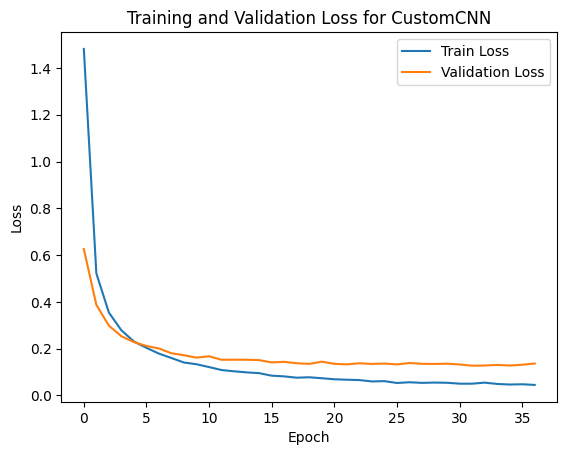

In [14]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_36/4092758933.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Testing time: 3.45 sec  |  Throughput: 365.60 samples/sec
Confusion Matrix:
 [[33  0  1 ...  0  0  0]
 [ 0 36  0 ...  0  0  0]
 [ 0  0 36 ...  0  0  0]
 ...
 [ 0  0  0 ... 27  0  0]
 [ 0  0  0 ...  0 38  0]
 [ 0  0  0 ...  0  0 35]]

Confusion Matrix (row-normalized):
[[0.917 0.    0.028 ... 0.    0.    0.   ]
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 1.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.974 0.   ]
 [0.    0.    0.    ... 0.    0.    1.   ]]


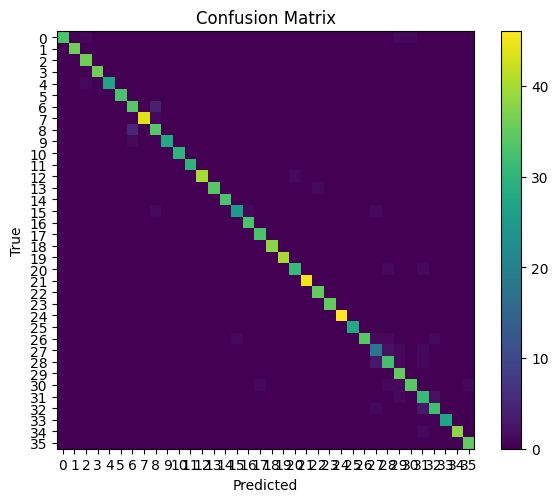

Per-class ROC AUC:
  Class 0: 1.0000
  Class 1: 1.0000
  Class 2: 1.0000
  Class 3: 1.0000
  Class 4: 1.0000
  Class 5: 1.0000
  Class 6: 0.9984
  Class 7: 1.0000
  Class 8: 0.9981
  Class 9: 1.0000
  Class 10: 1.0000
  Class 11: 1.0000
  Class 12: 1.0000
  Class 13: 1.0000
  Class 14: 1.0000
  Class 15: 0.9998
  Class 16: 1.0000
  Class 17: 1.0000
  Class 18: 1.0000
  Class 19: 1.0000
  Class 20: 0.9998
  Class 21: 1.0000
  Class 22: 1.0000
  Class 23: 1.0000
  Class 24: 1.0000
  Class 25: 1.0000
  Class 26: 0.9998
  Class 27: 0.9974
  Class 28: 0.9970
  Class 29: 1.0000
  Class 30: 0.9966
  Class 31: 0.9982
  Class 32: 0.9987
  Class 33: 1.0000
  Class 34: 1.0000
  Class 35: 1.0000
Micro-average ROC AUC: 0.9998
Macro-average ROC AUC: 0.9996


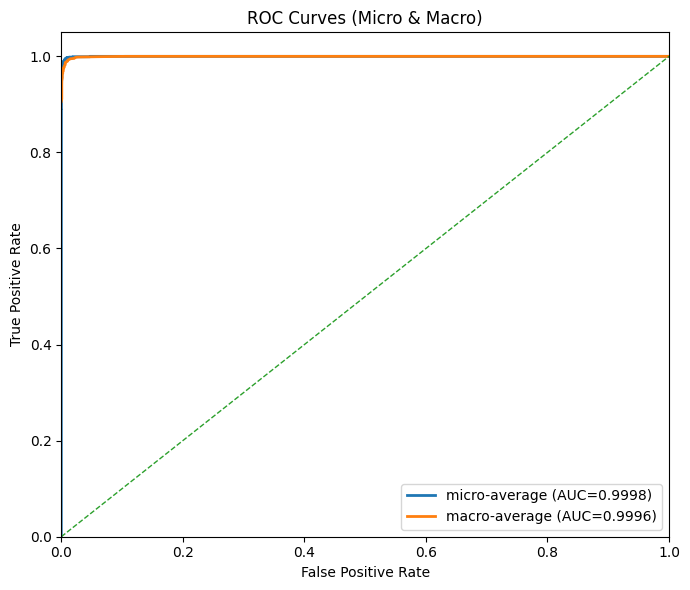

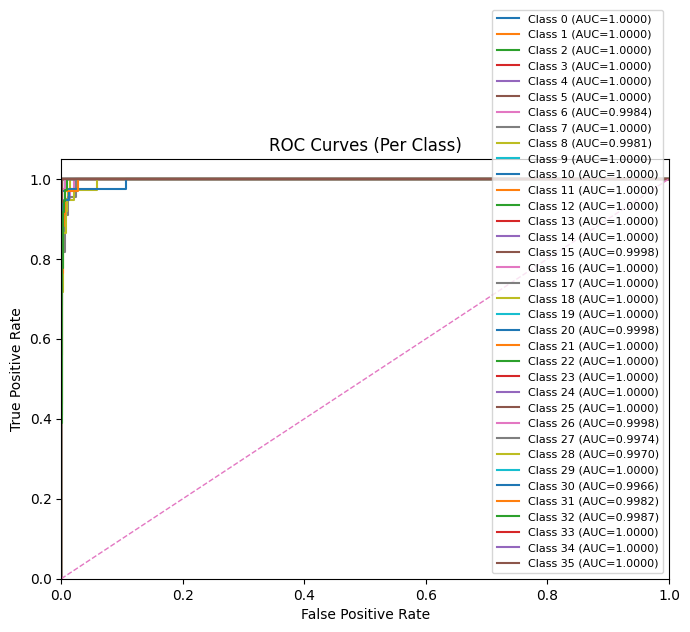


Classification Report (test):
              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        36
           1     1.0000    1.0000    1.0000        36
           2     0.9474    1.0000    0.9730        36
           3     1.0000    1.0000    1.0000        36
           4     1.0000    0.9643    0.9818        28
           5     1.0000    1.0000    1.0000        33
           6     0.8500    0.8947    0.8718        38
           7     1.0000    0.9778    0.9888        45
           8     0.8500    0.8718    0.8608        39
           9     1.0000    0.9655    0.9825        29
          10     1.0000    1.0000    1.0000        30
          11     1.0000    1.0000    1.0000        30
          12     1.0000    0.9756    0.9877        41
          13     1.0000    0.9714    0.9855        35
          14     1.0000    1.0000    1.0000        33
          15     0.9615    0.8929    0.9259        28
          16     0.9706    1.0000    0.9851       

In [15]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

all_logits   = []
all_probs    = []
all_preds    = []
all_labels   = []


loader = test_loader  

t_test_start = time.time()
with torch.no_grad():
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        with autocast(enabled=(device.type=="cuda")):
            logits = model(images)                        
            probs  = F.softmax(logits, dim=1)            

        preds = torch.argmax(probs, dim=1)

        all_logits.append(logits.detach().cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

t_test_end = time.time()
total_test_time_sec = t_test_end - t_test_start
n_samples = len(all_preds)
print(f"Testing time: {total_test_time_sec:.2f} sec  |  Throughput: {n_samples/total_test_time_sec:.2f} samples/sec")

all_logits = np.concatenate(all_logits, axis=0)
all_probs  = np.concatenate(all_probs, axis=0)
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = all_probs.shape[1]
class_indices = list(range(num_classes))


cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
print("Confusion Matrix:\n", cm)


def print_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    norm_cm = cm / row_sums
    print("\nConfusion Matrix (row-normalized):")
    with np.printoptions(precision=3, suppress=True):
        print(norm_cm)

print_cm(cm)


plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


y_true_bin = label_binarize(all_labels, classes=class_indices) if num_classes > 2 else all_labels
y_score    = all_probs

if num_classes == 2:
    
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"Binary ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

else:
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in class_indices:
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

   
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

   
    all_fpr = np.unique(np.concatenate([fpr[c] for c in class_indices]))
    
    mean_tpr = np.zeros_like(all_fpr)
    for c in class_indices:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print("Per-class ROC AUC:")
    for c in class_indices:
        print(f"  Class {c}: {roc_auc[c]:.4f}")
    print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average ROC AUC: {roc_auc['macro']:.4f}")

    # Plot micro & macro
    plt.figure(figsize=(7, 6))
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'micro-average (AUC={roc_auc["micro"]:.4f})')
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'macro-average (AUC={roc_auc["macro"]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro & Macro)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(7, 6))
    for c in class_indices:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f'Class {c} (AUC={roc_auc[c]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Per Class)')
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()


print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))


In [16]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-7d9w5p3n
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-7d9w5p3n
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:0

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

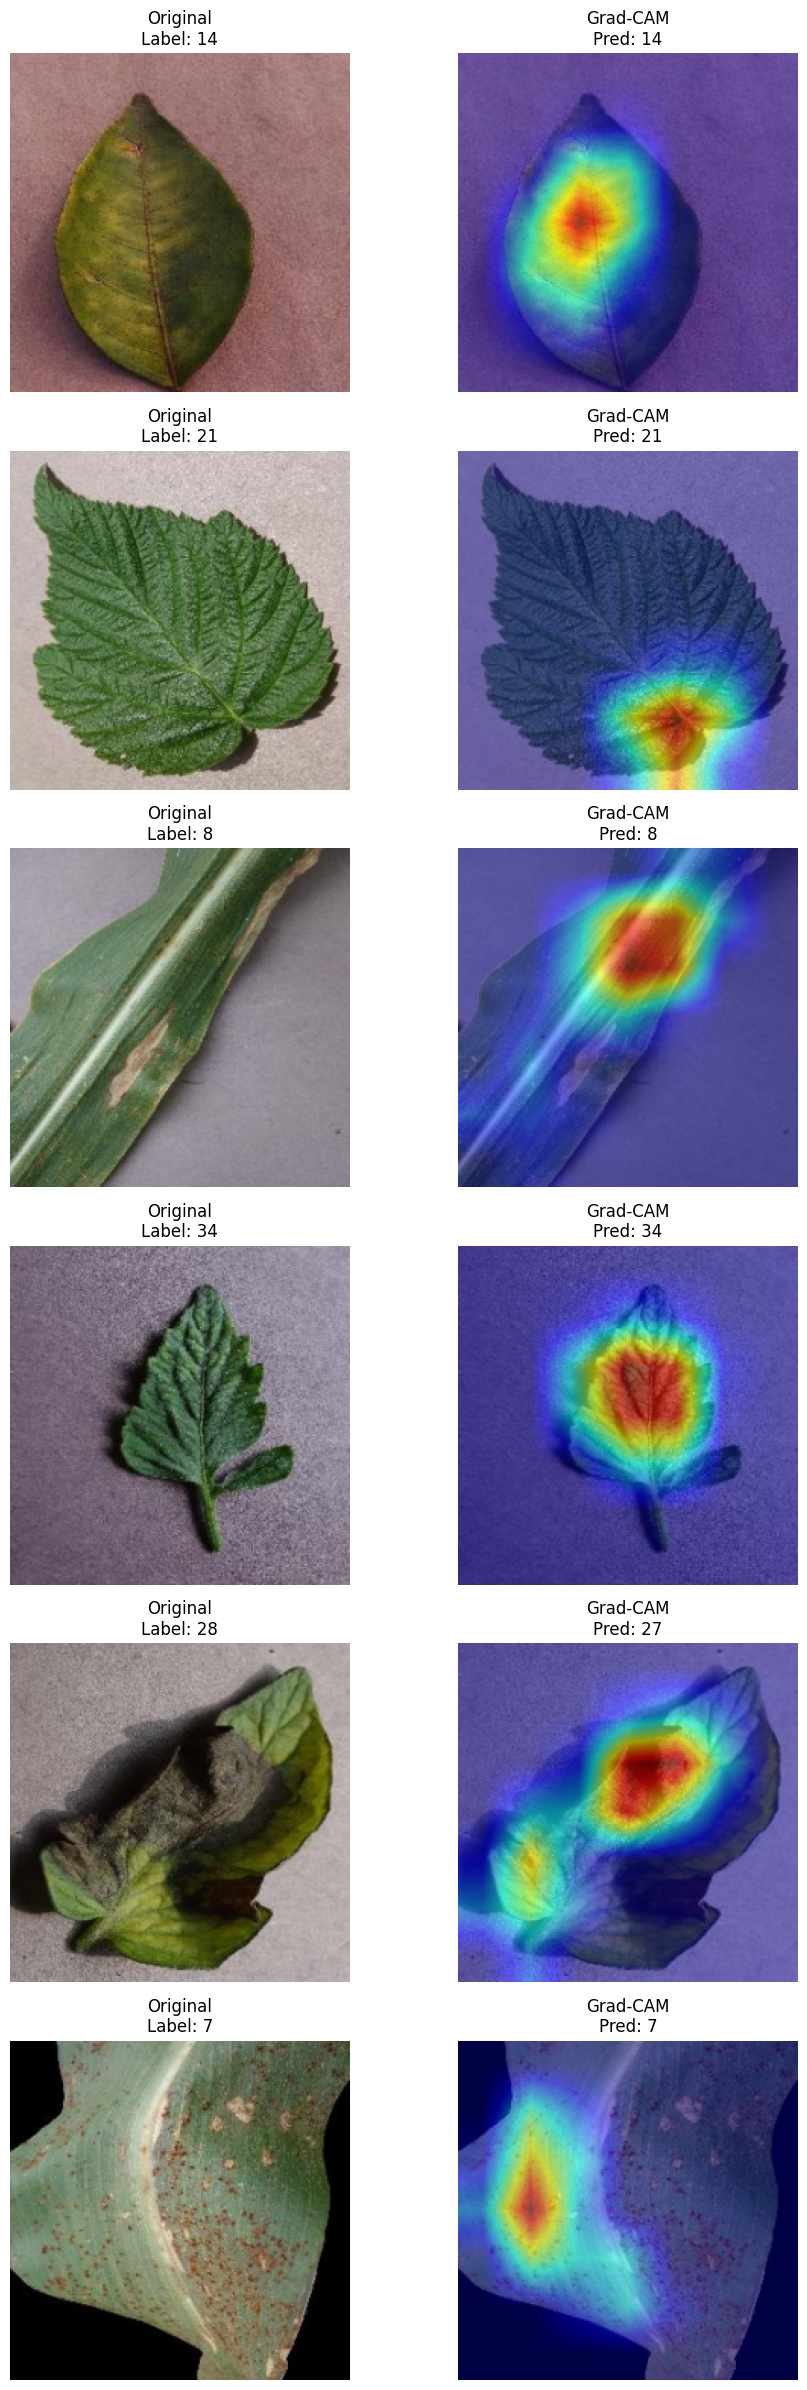

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

for p in model.parameters():
    p.requires_grad_(True)

target_layers = [model.features[-1]]

cam = GradCAM(model=model, target_layers=target_layers)

class_names = getattr(test_dataset, "classes", None) or [str(i) for i in range(1000)]
num_images = 6

plt.figure(figsize=(10, num_images * 4))

for i in range(num_images):
    sample_image, label = test_dataset[i]
    sample_image = sample_image.unsqueeze(0).to(device)

    original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    original_image_np = (original_image_np * 0.5) + 0.5
    original_image_np = original_image_np.clip(0, 1)

    outputs = model(sample_image)
    predicted_class = outputs.argmax(dim=1).item()
    targets = [ClassifierOutputTarget(predicted_class)]

    grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]
    result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

    plt.subplot(num_images, 2, 2*i + 1)
    plt.title(f"Original\nLabel: {class_names[label]}")
    plt.imshow(original_image_np)
    plt.axis('off')

    plt.subplot(num_images, 2, 2*i + 2)
    plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]}")
    plt.imshow(result)
    plt.axis('off')

plt.tight_layout()
plt.show()


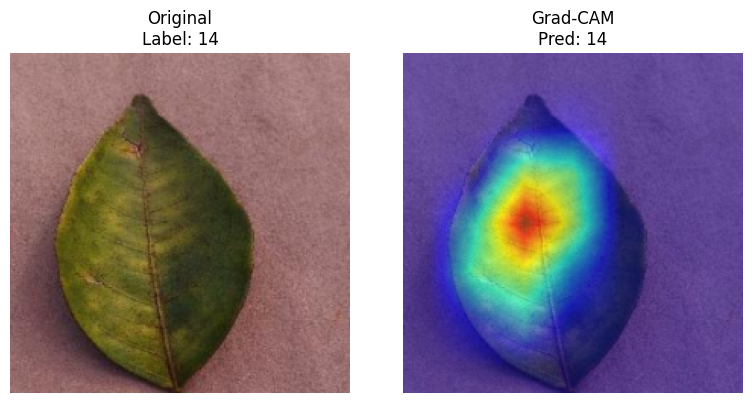

In [21]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

for p in model.parameters():
    p.requires_grad_(True)

target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

class_names = getattr(test_dataset, "classes", None) or [str(i) for i in range(1000)]

sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)

original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5
original_image_np = original_image_np.clip(0, 1)

outputs = model(sample_image)
predicted_class = outputs.argmax(dim=1).item()
targets = [ClassifierOutputTarget(predicted_class)]

grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
heatmap = grayscale_cam[0]
result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original\nLabel: {class_names[label]}")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]}")
plt.imshow(result)
plt.axis('off')

plt.tight_layout()
plt.show()
